In [3]:
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics
from pathlib import Path
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import eli5
#from eli5.sklearn import PermutationImportance
import shap

# 解决中文乱码问题
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams["axes.unicode_minus"]=False 

c:\Users\Dell\anaconda3\envs\lipu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data=pd.read_csv('./use.csv')
train_data,test_data=train_test_split(data,test_size=0.2, random_state=1314)
feature=train_data.drop(['Sel','Unnamed: 0'],axis=1)
label=train_data['Sel']

In [5]:
kfold = KFold(n_splits = 5, random_state = 1314, shuffle = True)

In [6]:
def optuna_objective(trial):
    iterations=trial.suggest_int('iterations',100,1000,10)
    max_depth=trial.suggest_int("max_depth",2,15,1)
    l2_leaf_reg=trial.suggest_float("l2_leaf_reg",1,4)
    learning_rate=trial.suggest_float("learning_rate",0.05,0.3)
    reg=cb.CatBoostRegressor(iterations=iterations,
                             max_depth=max_depth,
                             l2_leaf_reg=l2_leaf_reg,
                             learning_rate=learning_rate,
                             silent=True
                             )
    loss=cross_val_score(reg,feature,label,cv=kfold,error_score='raise')
    return pow(abs(loss.mean()),0.5)

In [7]:
def optimizer_optuna(n_trials):
    algo=optuna.samplers.TPESampler(n_startup_trials=10,n_ei_candidates=24)
    study=optuna.create_study(sampler=algo,direction="maximize")
    study.optimize(optuna_objective,n_trials=n_trials,show_progress_bar=True)
    print("\n","\n","best params: ", study.best_trial.params,
          "\n","\n","best score: ", study.best_trial.values,
          "\n")
    
    return study.best_trial.params, study.best_trial.values

In [6]:
optimizer_optuna(10)

[I 2023-04-25 14:32:02,479] A new study created in memory with name: no-name-1b93dc25-1bbc-4ed8-ae6e-4d8bb97121f2
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-04-25 14:32:06,031] Trial 0 finished with value: 0.8778746138270339 and parameters: {'iterations': 710, 'max_depth': 4, 'l2_leaf_reg': 2.6653944146810415, 'learning_rate': 0.16424349220788137}. Best is trial 0 with value: 0.8778746138270339.
[I 2023-04-25 14:32:25,913] Trial 1 finished with value: 0.8813582853338431 and parameters: {'iterations': 860, 'max_depth': 9, 'l2_leaf_reg': 3.169163312232394, 'learning_rate': 0.213603696565564}. Best is trial 1 with value: 0.8813582853338431.
[I 2023-04-25 14:32:27,239] Trial 2 finished with value: 0.8487145445117631 and parameters: {'iterations': 550, 'max_depth': 2, 'l2_leaf_reg': 3.860488466192625, 'learning_rate': 0.2365209593389322}. Best is trial 1 with value: 0.8813582853338431.
[I 2023-04-25 14:32:33,218] Trial 3 finished with value: 0.8928817030598926 and parameters: {'iterations': 640, 'max_depth': 7, 'l2_leaf_reg': 3.3453989007800673, 'learning_rate': 0.14045836209433626}. Best is trial 3 with value: 0.8928817030598926.
[I 20

({'iterations': 640,
  'max_depth': 7,
  'l2_leaf_reg': 3.3453989007800673,
  'learning_rate': 0.14045836209433626},
 [0.8928817030598926])

In [8]:
model = cb.CatBoostRegressor(iterations=1000,max_depth=7,l2_leaf_reg=2.04534912107800673,
                             subsample=0.6,silent=True,random_state=1314,learning_rate=0.140355596209433626).fit(X=feature , y=label)
r2_score = cross_val_score(model, feature, label, cv=kfold, scoring='r2').mean()
rmse_score = pow(abs(cross_val_score(model, feature, label, cv=kfold, scoring='neg_mean_squared_error').mean()),0.5)
print('r2:',r2_score)
print('rmse:',rmse_score)

r2: 0.8030224926883186
rmse: 9.560100503764563


In [9]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
test_x = test_data.drop(['Sel','Unnamed: 0'],axis=1)
test_y = test_data['Sel']
print('r2:',r2_score(label,model.predict(feature)))
print('MAE:',pow(mean_squared_error(label,model.predict(feature)),0.5))
print('测试集得分为：', r2_score(test_y,model.predict(test_x)),pow(mean_squared_error(test_y,model.predict(test_x)),0.5))

r2: 0.9998520448543576
MAE: 0.265600883907032
测试集得分为： 0.8013105406987113 9.554141293609215


In [10]:
# 预测1
Y1=model.predict(test_data.drop(['Sel','Unnamed: 0'],axis=1))
Y2=test_data['Sel']
d={'Y_pred':Y1,
   'Y_True':Y2
   }
pred_show=pd.DataFrame(d)

In [11]:
# 预测2
Y_1=model.predict(feature)
Y_2=label
d_1={'Y_pred':Y_1,
   'Y_True':Y_2
   }
pred_show_1=pd.DataFrame(d_1)

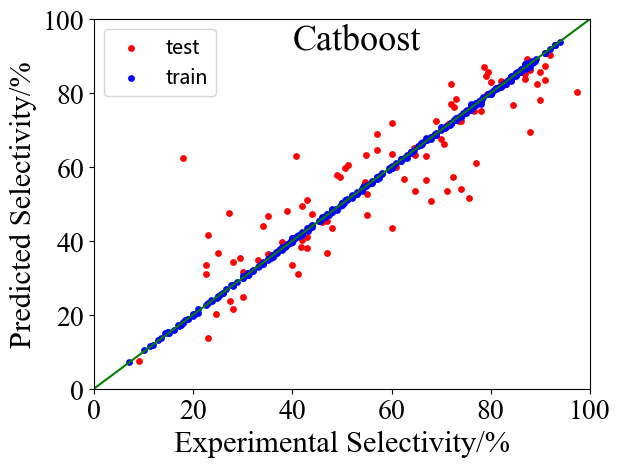

In [20]:
plt.scatter(pred_show.iloc[:,1],pred_show.iloc[:,0],color='r',s=15,label='test')
plt.scatter(pred_show_1.iloc[:,1],pred_show_1.iloc[:,0],color='b',s=15,label='train')
plt.xlim((0,100))
plt.xlabel('Experimental Selectivity/%',fontsize=22,font=Path('..\TimesNewRoman.ttf'))
plt.xticks(fontsize=20,fontname='Times New Roman')
plt.ylim((0,100))
plt.ylabel('Predicted Selectivity/%',fontsize=22,font=Path('..\TimesNewRoman.ttf'))
plt.yticks(fontsize=20,fontname='Times New Roman')
plt.plot([0,100],[0,100],color='g')
plt.text(40,92,'Catboost',fontsize=26,font=Path('..\TimesNewRoman.ttf'))
plt.legend(fontsize=14)
plt.show()

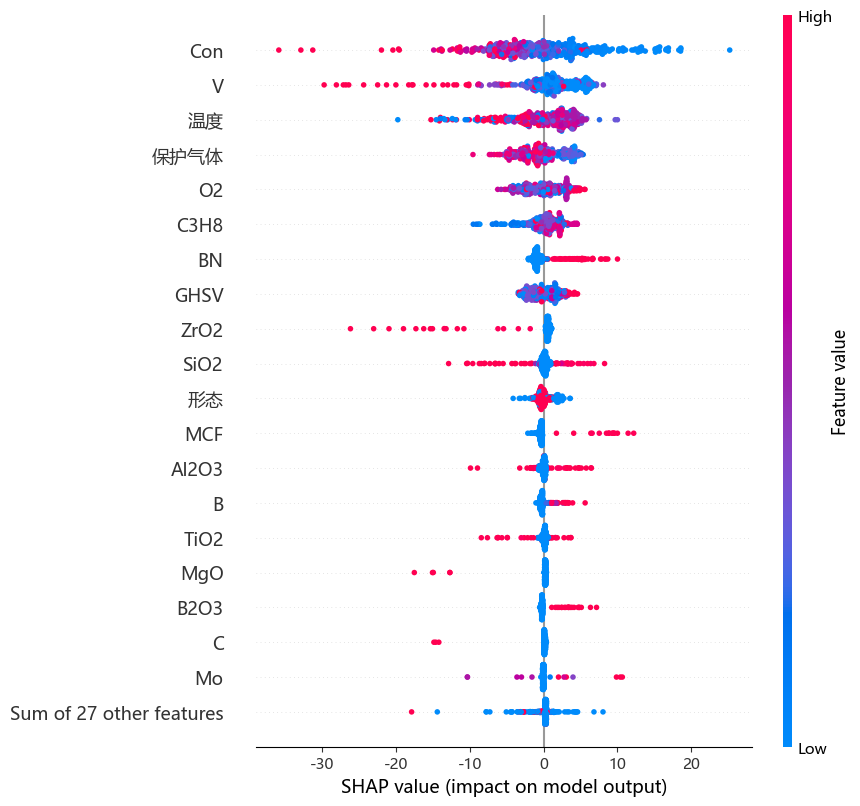

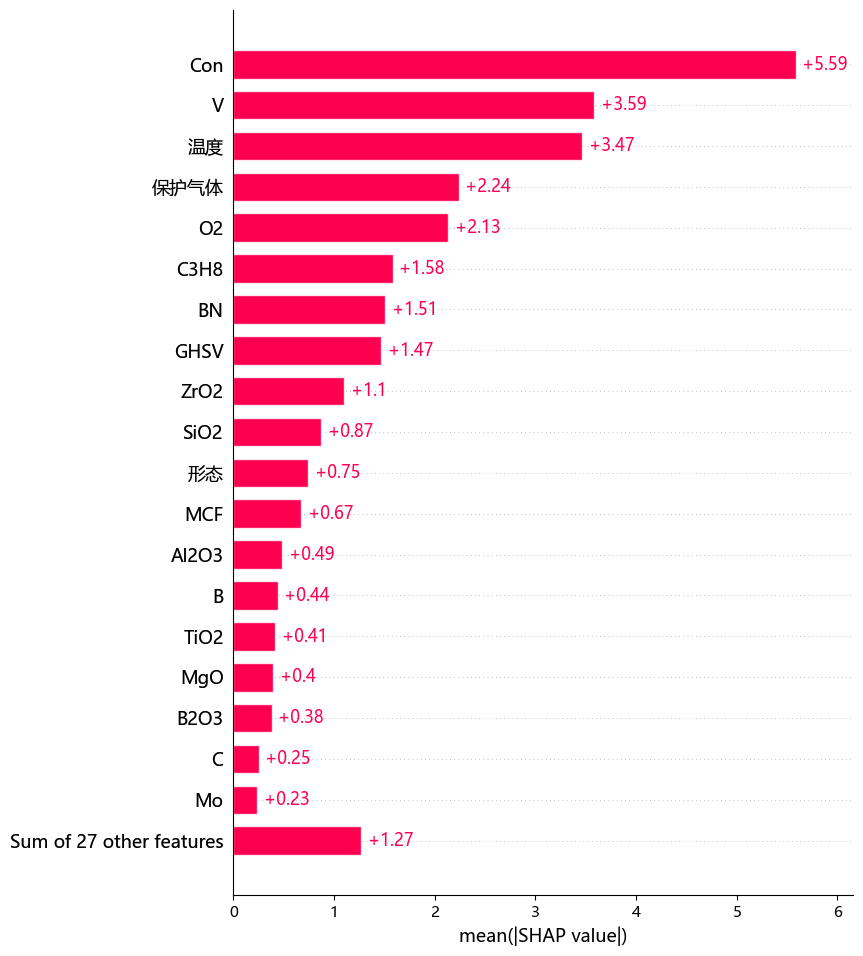

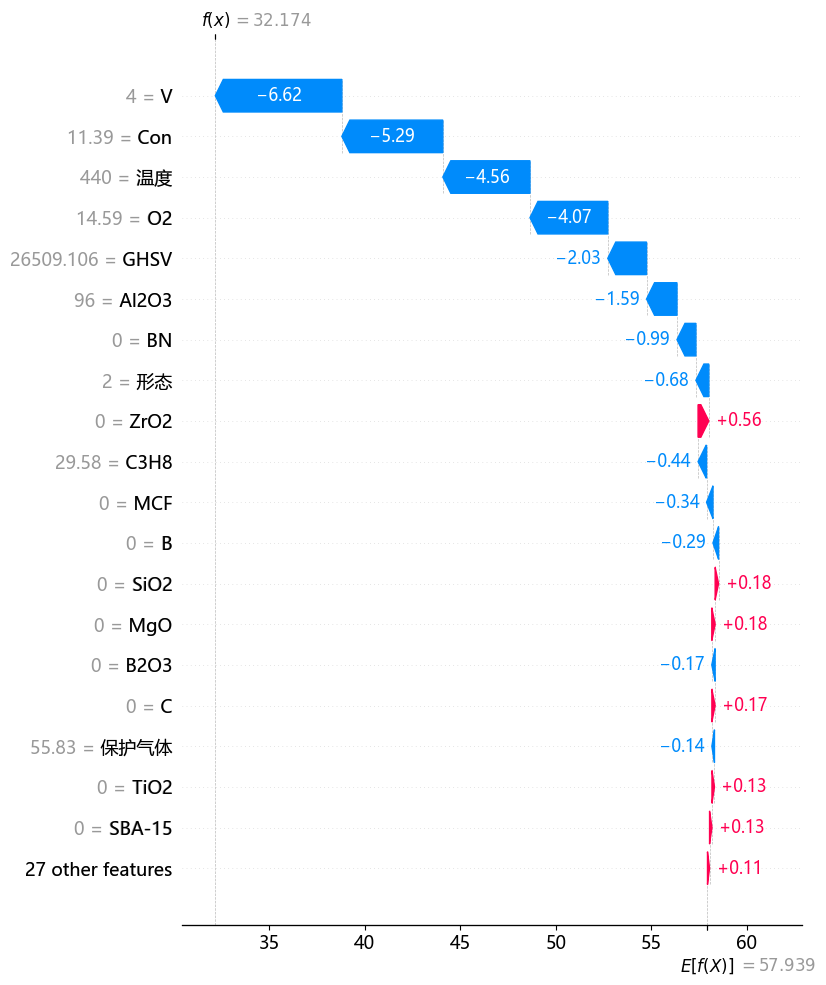

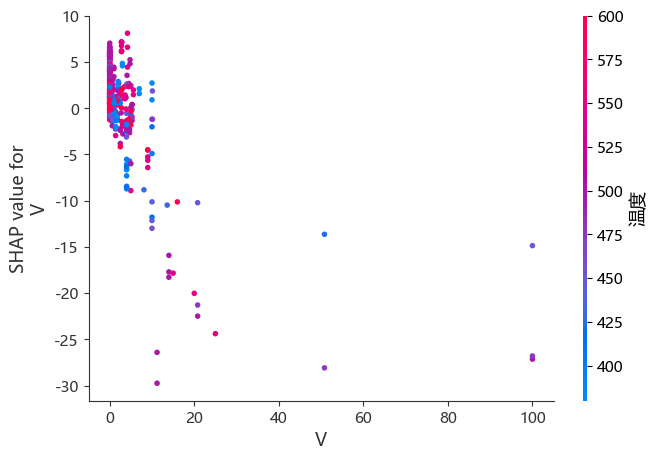

In [13]:
# shap提高解释性
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer(feature)
shap.plots.beeswarm(shap_values, max_display=20)
shap.plots.bar(shap_values, max_display=20)
shap.plots.waterfall(shap_values[0], max_display=20)
shap.plots.force(shap_values[0])
shap.force_plot(explainer.expected_value, shap_values.values, feature)
shap.dependence_plot("V", shap_values.values, feature, interaction_index='温度')

In [13]:
perm = PermutationImportance(model, random_state=1).fit(test_x, test_y)
eli5.show_weights(perm, feature_names = test_x.columns.tolist())

Weight,Feature
0.4133 ± 0.0973,Con
0.2073 ± 0.0545,V
0.1829 ± 0.0618,温度
0.1339 ± 0.0554,O2
0.1290 ± 0.0233,C3H8
0.1080 ± 0.0234,保护气体
0.0672 ± 0.0156,ZrO2
0.0460 ± 0.0276,BN
0.0289 ± 0.0130,MCF
0.0268 ± 0.0138,形态
